In [158]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import copy
from matplotlib import colors

In [2]:
import urllib.request as request
import pandas as pd
import geopandas as gpd
from datetime import datetime

Gather data from Italy and Hubei province to check the difference. Notice that the Hubei data are available from the moment in which the number of infected people was greater than 400.

In [3]:
data_it = []

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
csv_file = request.urlopen(url).read().decode('utf8').split('\n')
csv_reader = csv.DictReader(csv_file)
    
for row in csv_reader:
    data_it.append(int(row['totale_casi']))
        
days_it = np.arange(0,len(data_it), 1)

In [4]:
data_hub = []
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
csv_file = request.urlopen(url).read().decode('utf8').split("\n")
csv_reader = csv.DictReader(csv_file)


for row in csv_reader:
    if row['Country/Region'] == 'China':
        if row['Province/State'] == 'Hubei':
            data_hub = np.array(list(row.values())[4:-1]).astype('int')
                
days_hub = np.arange(0,len(data_hub), 1)

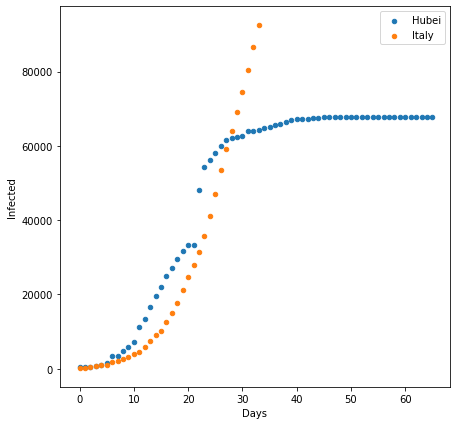

In [5]:
plt.figure(figsize=(7,7))
data_it = np.array(data_it)
plt.scatter(days_hub, data_hub, label = 'Hubei', s = 20)
plt.scatter(np.array(days_it[data_it > days_hub[0]]), data_it[data_it > days_hub[0]], label = 'Italy', s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Infected')
plt.savefig('italy_hubei.png', dpi = 300, bbox_inches = 'tight')
plt.show()

This might suggest that Italy is still in growing in a sub-exponential fashion no plateau in sight, whereas Hubei around day 25 started to show a slowing-down in the number of new infections.

However, we should note that we should shift the temporal axis for each curve since we don't really know when each outbreak started. If we do this for Italy vs Hubei, and for other countries as well, we find a remarkable superposition at least in the initial exponential phase of the outbreak.

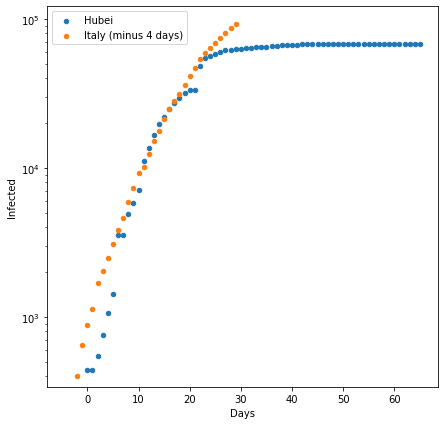

In [10]:
plt.figure(figsize=(7,7))
data_it = np.array(data_it)
plt.scatter(days_hub, data_hub, label = 'Hubei', s = 20)
plt.scatter(np.array(days_it[data_it > days_hub[0]])-4, data_it[data_it > days_hub[0]], label = 'Italy (minus 4 days)', s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Infected')
plt.yscale('log')
plt.savefig('italy_hubei_tras.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In a log scale, we see the sub-exponential increase of Italy's cases and a possible plateau should be reached in 10-20 days.

In [11]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

clist = ['Italy', 'Spain', 'Germany', 'US', 'France', 'United Kingdom']
tlist = []

for country in clist:
    temp = []
    
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Country/Region'] == country:
            temp.append(np.array(list(row.values())[4:]).astype('int'))
    tlist.append(np.sum(temp, axis = 0))

In [12]:
url= 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
clist = ['Italy', 'Spain', 'Germany', 'US', 'France', 'United Kingdom']
dlist = []

for country in clist:
    temp = []
    
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Country/Region'] == country:
            temp.append(np.array(list(row.values())[4:]).astype('int'))
    dlist.append(np.sum(temp, axis = 0))
        

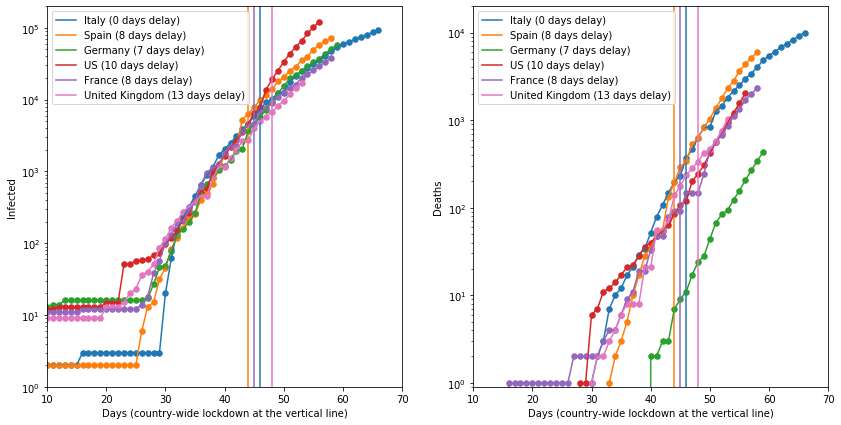

In [13]:
days = [np.arange(0, len(t), 1) for t in tlist]
days_t = [0, 8, 7, 10, 8, 13]
ld_list = [46, 52, None, None, 53, 61] # 46 is the index for 09/03, 52 for 15/03
                                         # 61 for 24/03

colorlist = plt.cm.tab10(np.linspace(0,len(days_t)/10,len(days_t)))    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))

for x, y, l, dt, ld, c in zip(days, tlist, clist, days_t, ld_list, colorlist):
    ax[0].plot(x-dt,y, label = l + ' (' + str(dt) + ' days delay)', color = c)
    ax[0].scatter(x-dt,y, color = c, s= 30)
    if ld != None:
        ax[0].axvline(x=ld-dt, color = c)
        
ax[0].set_xlabel('Days (country-wide lockdown at the vertical line)')
ax[0].set_ylabel('Infected')
ax[0].set_yscale('log')
ax[0].set_xlim(10,70)
ax[0].set_ylim(1,200000)
ax[0].legend(loc = 2)

for x, y, l, dt, ld, c in zip(days, dlist, clist, days_t, ld_list, colorlist):
    ax[1].plot(x-dt,y, label = l + ' (' + str(dt) + ' days delay)', color = c)
    ax[1].scatter(x-dt,y, color = c, s = 30)
    if ld != None:
        ax[1].axvline(x=ld-dt, color = c)
    
ax[1].set_xlabel('Days (country-wide lockdown at the vertical line)')
ax[1].set_ylabel('Deaths')
ax[1].set_yscale('log')
ax[1].set_xlim(10,70)
ax[1].set_ylim(0.9,20000)
ax[1].legend(loc = 2)


plt.savefig('countries.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [14]:
def read_country_data(country_name, url_list, fnames):
    data = []
    
    for url in url_list:
        csv_file = request.urlopen(url).read().decode('utf8').split("\n")
        csv_reader = csv.DictReader(csv_file)
        temp = []

        for row in csv_reader:
            if row['Country/Region'] == country_name:
                temp.append(np.array(list(row.values())[-1]).astype('int'))
        data.append(np.sum(temp, axis = 0))
    return dict(zip(fnames, data))

def current_world_df():
    url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    
    url_list = [url_confirmed, url_deaths, url_recovered]
    
    csv_confirmed = request.urlopen(url_confirmed).read().decode('utf8').split("\n")
    
    # get the list of the countries in the csv file
    csv_reader = csv.DictReader(csv_confirmed)
    countries_list = []
    for row in csv_reader:
        countries_list.append(row['Country/Region'])
    countries_list = list(set(countries_list))
    
    fnames = ['confirmed', 'deaths', 'recovered']
    
    clist = []
    for country_name in countries_list:
        clist.append(read_country_data(country_name, url_list, fnames))

    return pd.DataFrame(dict(zip(countries_list, clist))).T

In [15]:
cworld_df = current_world_df()

In [16]:
cworld_df

,confirmed,deaths,recovered
Georgia,90,0,14
Romania,1452,37,139
Djibouti,14,0,0
Liechtenstein,56,0,0
United Kingdom,17312,1021,151
...,...,...,...
Colombia,608,6,10
Liberia,3,0,0
West Bank and Gaza,98,1,18
Greece,1061,32,52


In [17]:
def get_df_data(df, fname, new_name = 'Regions'):
    tlist = df[fname].to_list()

    tdict = dict(zip([new_name,fname],[df.index.to_list(), tlist]))
    new_df = pd.DataFrame(tdict)

    return new_df

get_df_data(cworld_df, 'confirmed', new_name = 'name')

,name,confirmed
0,Georgia,90
1,Romania,1452
2,Djibouti,14
3,Liechtenstein,56
4,United Kingdom,17312
...,...,...
172,Colombia,608
173,Liberia,3
174,West Bank and Gaza,98
175,Greece,1061


In [175]:
worldmap_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

worldmap_df.drop(worldmap_df.index[worldmap_df['name'] == 'Antarctica'], inplace = True)
worldmap_df.drop(worldmap_df.index[worldmap_df['name'] == 'Fr. S. Antarctic Lands'], inplace = True)

In [176]:
name_old = ['United States of America', 'Dominican Rep.', "Côte d'Ivoire", 'Macedonia', 'South Korea', 'Palestine',
            'Central African Rep.', 'Bosnia and Herz.', 'Taiwan', 'Eq. Guinea', 'Dem. Rep. Congo',
            'Congo', 'eSwatini']
name_new = ['US', 'Dominican Republic', "Cote d'Ivoire", 'North Macedonia', 'Korea, South', 'West Bank and Gaza',
            'Central African Republic', 'Bosnia and Herzegovina', 'Taiwan*', 'Equatorial Guinea', 'Congo (Kinshasa)',
            'Congo (Brazzaville)', 'Eswatini']

In [177]:
for nold, nnew in zip(name_old, name_new):
    idx = worldmap_df.index[worldmap_df['name'] == nold]
    worldmap_df.at[idx, 'name'] =  nnew

In [178]:
list(set(list(worldmap_df['name']))-set(list(cworld_df.index.values)))

['Vanuatu',
 'Puerto Rico',
 'Yemen',
 'New Caledonia',
 'Botswana',
 'North Korea',
 'Myanmar',
 'W. Sahara',
 'Lesotho',
 'N. Cyprus',
 'Falkland Is.',
 'Turkmenistan',
 'Sierra Leone',
 'Malawi',
 'Tajikistan',
 'Greenland',
 'Solomon Is.',
 'Burundi',
 'Somaliland',
 'S. Sudan']

In [179]:
list(set(list(cworld_df.index.values)) - set(list(worldmap_df['name'])))

['Liechtenstein',
 'Antigua and Barbuda',
 'Bahrain',
 'Dominica',
 'Cabo Verde',
 'Barbados',
 'Holy See',
 'MS Zaandam',
 'Andorra',
 'Singapore',
 'Mauritius',
 'Saint Vincent and the Grenadines',
 'Saint Lucia',
 'Grenada',
 'Maldives',
 'Saint Kitts and Nevis',
 'Malta',
 'Diamond Princess',
 'Seychelles',
 'Monaco',
 'San Marino',
 'Burma']

In [180]:
confirmed_world = get_df_data(cworld_df, 'confirmed', new_name = 'name')
merged_world = worldmap_df.set_index('name').join(confirmed_world.set_index('name'))

In [181]:
merged_world['log_value'] = np.log10(merged_world['confirmed'])
merged_world

,pop_est,continent,iso_a3,gdp_md_est,geometry,confirmed,log_value
name,,,,,,,
Fiji,920938,Oceania,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",5.0,0.698970
Tanzania,53950935,Africa,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",14.0,1.146128
W. Sahara,603253,Africa,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
Canada,35623680,North America,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",5576.0,3.746323
US,326625791,North America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",121478.0,5.084498
...,...,...,...,...,...,...,...
Serbia,7111024,Europe,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",659.0,2.818885
Montenegro,642550,Europe,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",84.0,1.924279
Kosovo,1895250,Europe,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",91.0,1.959041


C:\Users\Giorgio\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


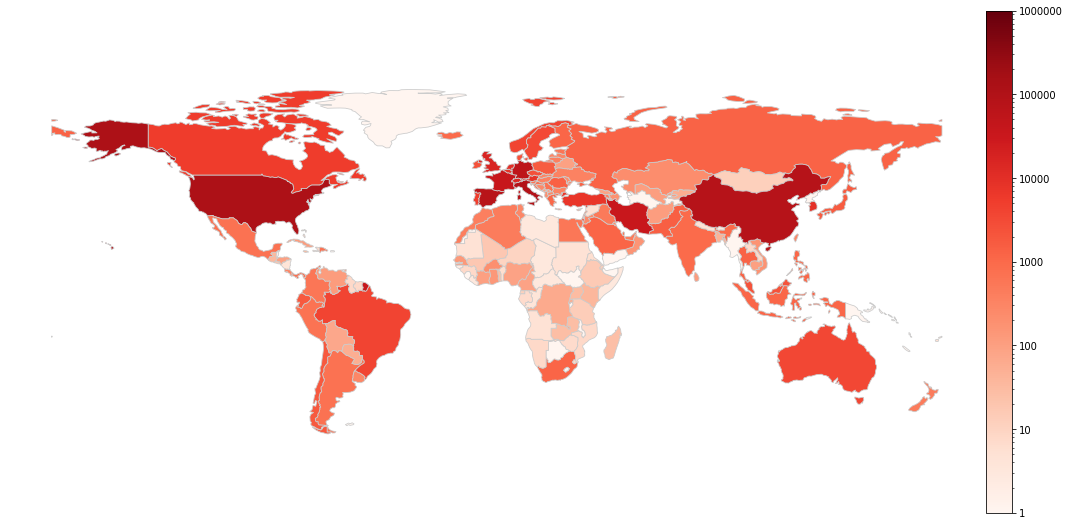

In [182]:
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis('off')
merged_world.plot(column = 'log_value', cmap = 'Reds', ax = ax, linewidth = 0.8,
                  edgecolor = '0.8', vmin = 0, vmax = 6, legend = False)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=colors.LogNorm(vmin=1, vmax=10**6))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.025, pad=0)
cbar.ax.set_yticklabels([1, 10, 100, 1000, 10000, 100000, 1000000]) 
plt.savefig('world.png', dpi = 300, bbox_inches = 'tight')
plt.show()

All major countries are following the same curve after an initial transient, and only the US show a significant divergence from the others. This might be due to the way we count the infections, but at the same time it is a strong suggestion that all countries will find themselves in an identical situation in the long time limit. At the same time, the death rate is substantially different, suggesting that there might be some mismatchs in how the COVID-related deaths are counted with respect to the infections. However, note that all the curves increase in a similar way, so some of them might just be more delayed.

Now let's gather the data region-by-region in Italy.

In [94]:
def read_italy_region(region_name, *args):
    fields = [[] for _ in args]
    
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
    csv_file = request.urlopen(url).read().decode('utf8').split("\n")
    csv_reader = csv.DictReader(csv_file)
    
    for row in csv_reader:
        if row['denominazione_regione'] == region_name:
            for i, arg in enumerate(args):
                fields[i].append(int(row[arg]))
                    
    return fields

In [95]:
fields_names = ["totale_casi", "totale_attualmente_positivi", "deceduti", "dimessi_guariti", "tamponi",
                "totale_ospedalizzati", "terapia_intensiva"]
#fields_names_lab = ['Totale casi', 'Totale positivi', 'Deceduti', 'Guariti', 'Tamponi',
#                    'Ospedalizzati', 'Terapia intensiva']

fields_names_lab = ['Infected', 'Current cases', 'Deaths', 'Recovered', 'Tested', 'Hospitalized', 'Intensive care']

regions_list = []

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
csv_file = request.urlopen(url).read().decode('utf8').split("\n")
csv_reader = csv.DictReader(csv_file)
line_count = 0
for row in csv_reader:
    regions_list.append(row['denominazione_regione'])
        
regions_list = list(set(regions_list))

In [96]:
def create_dict(regions_list, fields_names):
    rlist = []
    for region_name in regions_list:
        temp = zip(fields_names, read_italy_region(region_name, *fields_names))
        rlist.append(dict(temp))

    return dict(zip(regions_list, rlist))

In [97]:
r_timeseries = create_dict(regions_list, fields_names)

In [98]:
regions_dataframe = pd.DataFrame(r_timeseries).T

Let's look at what might seem as the top three regions in Italy, Lombardia, Emilia-Romagna and Veneto.

In [99]:
nlist = ['Veneto', 'Lombardia', 'Emilia Romagna']

def plot_comparison(regions_dataframe, nlist, fname, fname_lab):
    for name in nlist:
        data = regions_dataframe.at[name, fname]
        plt.scatter(np.arange(1,len(data)+1, 1), data, label = name, s = 20)
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel(fname_lab)
    plt.show()

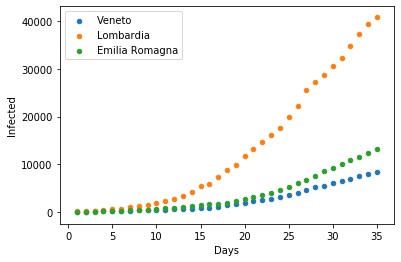

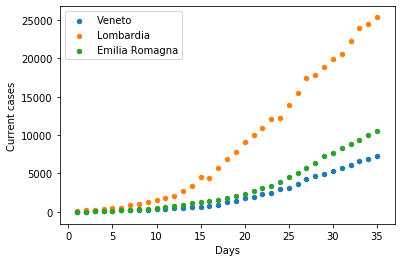

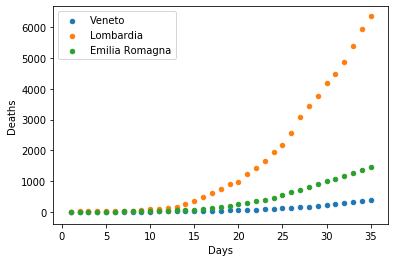

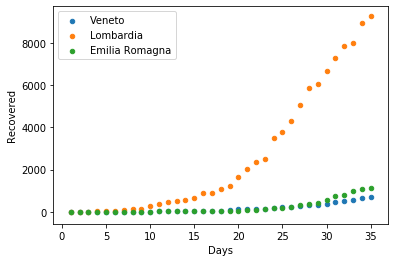

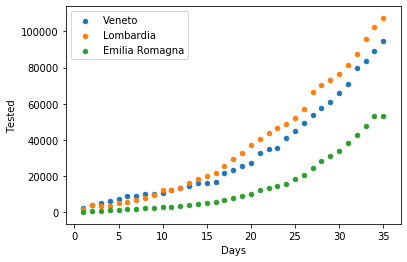

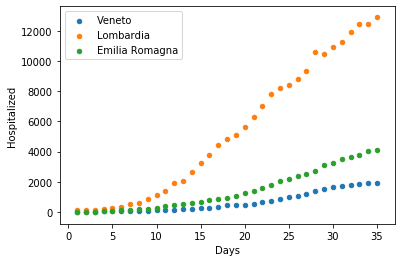

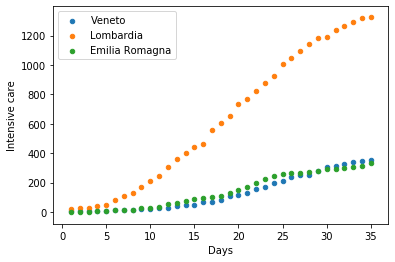

In [100]:
for fname, fname_lab in zip(fields_names, fields_names_lab):
    plot_comparison(regions_dataframe, nlist, fname, fname_lab)

This suggests that the number of tests performed plays a huge role in region-to-region comparison. Hence we should always normalize the number of infected to the number of tests performed. Let's build a dataframe merged together with geographical data to plot a map.

In [101]:
pos_tested = []
for name, data in r_timeseries.items():
    temp = np.array(data['totale_casi'])[-1]/np.array(data['tamponi'])[-1]
    pos_tested.append(temp*100)

pt_dict = dict(zip(['Regions','Percentage'],[regions_list, pos_tested]))
df = pd.DataFrame(pt_dict)

idx_trento = df.index[df['Regions'] == 'P.A. Trento']
idx_bolzano = df.index[df['Regions'] == 'P.A. Bolzano']

taa_p = (df.loc[idx_trento]['Percentage'].to_numpy() + df.loc[idx_bolzano]['Percentage'].to_numpy())/2
df.drop(idx_trento, inplace = True)
df.at[idx_bolzano, 'Regions'] = 'Trentino-Alto Adige'
df.at[idx_bolzano, 'Percentage'] = taa_p
df.at[df.index[df['Regions'] == 'Emilia Romagna'], 'Regions'] = 'Emilia-Romagna'

In [102]:
fp = '../italia/ConfiniRegionali/ConfiniRegionali.shp'
map_df = gpd.read_file(fp)

merged_ppos = map_df.set_index('DEN_REG').join(df.set_index('Regions'))

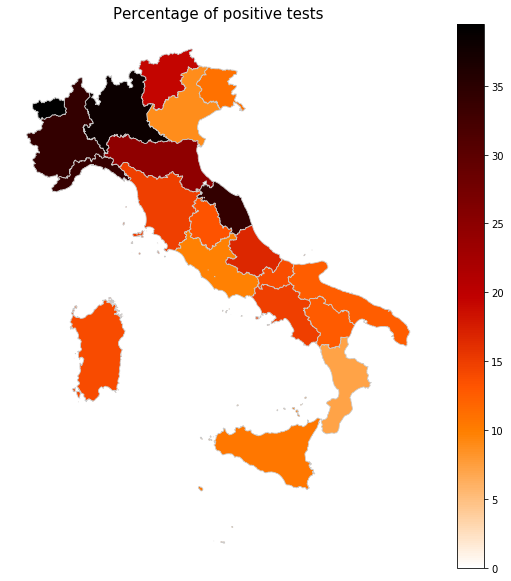

In [103]:
variable = 'Percentage'
fig, ax = plt.subplots(1,figsize=(10,10))

merged_ppos.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax,
            edgecolor = '0.8', vmin = 0, legend = True)
ax.axis('off')
ax.set_title('Percentage of positive tests', fontdict={'fontsize':'15'})
plt.savefig('map.jpg', dpi = 300, bbox_inches = 'tight')

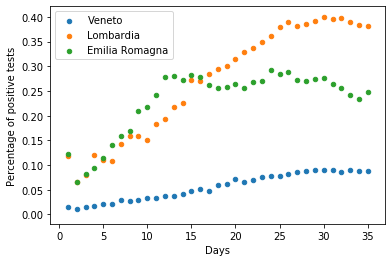

In [104]:
for name in nlist:
    data = np.array(regions_dataframe.at[name, 'totale_casi'])/np.array(regions_dataframe.at[name, 'tamponi'])
    plt.scatter(np.arange(1,len(data)+1, 1), data, label = name, s = 20)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Percentage of positive tests')
plt.show()

We can also try different things. Let's look at the current situation and at the day-by-day increase.

In [118]:
def get_current_df(regions_dataframe, delay_day = 0):
    df = copy.deepcopy(regions_dataframe)
    for index, row in df.iterrows():
        for column in df:
            df.loc[index][column] = (row[column][-1-delay_day])
            
    idx_trento = 'P.A. Trento'
    idx_bolzano = 'P.A. Bolzano'
        
    for fname in df:
        taa = df.loc[idx_trento][fname] + df.loc[idx_bolzano][fname]
        df.at[idx_bolzano, fname] = taa
      
    df.drop(idx_trento, inplace = True)
    df = df.rename(index={'P.A. Bolzano':'Trentino-Alto Adige'}) 
    df = df.rename(index={'Emilia Romagna':'Emilia-Romagna'}) 

    return df

current_df = get_current_df(regions_dataframe)
current_df.sort_values('totale_casi', ascending = False)

,totale_casi,totale_attualmente_positivi,deceduti,dimessi_guariti,tamponi,totale_ospedalizzati,terapia_intensiva
Lombardia,41007,25392,6360,9255,107398,12941,1328
Emilia-Romagna,13119,10535,1443,1141,52991,4102,333
Veneto,8358,7251,392,715,94784,1941,355
Piemonte,8206,7268,684,254,24058,3428,443
Toscana,4122,3786,215,121,27579,1386,275
Marche,3558,3160,386,12,10431,1168,168
Liguria,3076,2279,377,420,9100,1243,166
Trentino-Alto Adige,2808,2327,193,288,16087,721,131
Lazio,2706,2362,136,208,27744,1195,133
Campania,1759,1556,117,86,11805,611,135


In [106]:
it_current = pd.DataFrame(current_df.sum())
it_current.columns = ['Italia']
it_current.T

,totale_casi,totale_attualmente_positivi,deceduti,dimessi_guariti,tamponi,totale_ospedalizzati,terapia_intensiva
Italia,97689.0,73880.0,10779.0,13030.0,454030.0,31292.0,3906.0


In [117]:
def get_increment_df(regions_dataframe, delay_day = 0):
    df = copy.deepcopy(regions_dataframe)
    for index, row in df.iterrows():
        for column in df:
            df.loc[index][column] = np.diff(row[column])[-1-delay_day]
            
    idx_trento = 'P.A. Trento'
    idx_bolzano = 'P.A. Bolzano'
        
    for fname in df:
        taa = df.loc[idx_trento][fname] + df.loc[idx_bolzano][fname]
        df.at[idx_bolzano, fname] = taa
      
    df.drop(idx_trento, inplace = True)
    df = df.rename(index={'P.A. Bolzano':'Trentino-Alto Adige'}) 
    df = df.rename(index={'Emilia Romagna':'Emilia-Romagna'}) 

    df.columns = ['inc_' + s for s in df.columns.to_list()]
    
    return df

increment_df = get_increment_df(regions_dataframe)
increment_df.sort_values('inc_deceduti', ascending = False)

,inc_totale_casi,inc_totale_attualmente_positivi,inc_deceduti,inc_dimessi_guariti,inc_tamponi,inc_totale_ospedalizzati,inc_terapia_intensiva
Lombardia,1592,883,416,293,4895,470,9
Emilia-Romagna,736,571,99,66,0,91,17
Piemonte,535,417,67,51,2547,-105,4
Veneto,428,338,30,60,5404,38,11
Marche,185,161,22,2,547,15,2
Liguria,254,193,19,42,923,45,-1
Toscana,305,275,17,13,1966,16,-2
Puglia,91,74,15,2,861,-3,1
Lazio,201,181,12,8,565,77,0
Abruzzo,160,142,12,6,727,16,-2


In [108]:
it_inc = pd.DataFrame(increment_df.sum())
it_inc.columns = ['Italia']
it_inc.T

,inc_totale_casi,inc_totale_attualmente_positivi,inc_deceduti,inc_dimessi_guariti,inc_tamponi,inc_totale_ospedalizzati,inc_terapia_intensiva
Italia,5217.0,3815.0,756.0,646.0,24504.0,760.0,50.0


In [109]:
def plot_current(ax, fname, current_df, map_df, title):
    df = get_df_data(current_df, fname)
    
    merged = map_df.set_index('DEN_REG').join(df.set_index('Regions'))
    
    variable = fname
    merged.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax,
                edgecolor = '0.8', vmin = 0, legend = True)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize':'15'})

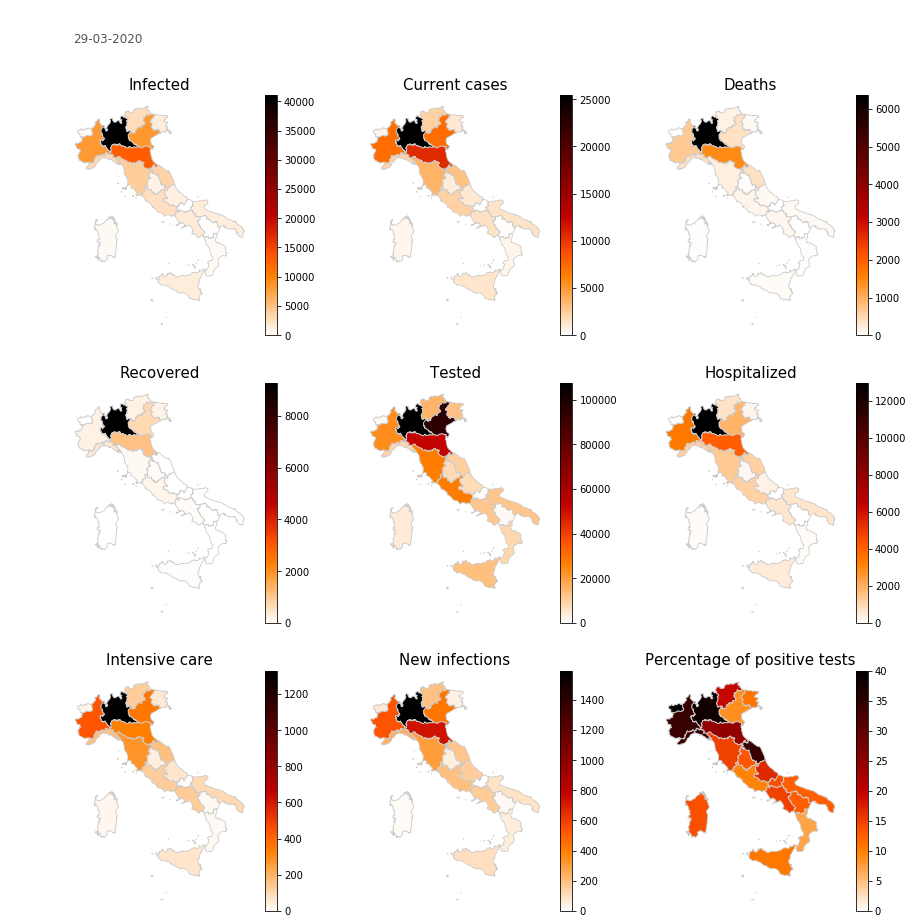

In [110]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

#names_plot = ['Totale', 'Attualmente positivi', 'Deceduti', 'Dimessi',
#              'Tamponi', 'Ospedalizzati', 'Terapia intensiva']

names_plot = ['Infected', 'Current cases', 'Deaths', 'Recovered', 'Tested', 'Hospitalized', 'Intensive care']


for i, fname, title in zip(np.ndenumerate(np.zeros((3,3))), fields_names, names_plot):
    plot_current(ax[i[0]], fname, current_df, map_df, title)

plot_current(ax[2,1], 'inc_totale_casi', increment_df, map_df, 'New infections')

variable = 'Percentage'
vmin, vmax  = 0,40
merged_ppos.plot(column = variable, cmap = 'gist_heat_r', linewidth = 0.8, ax = ax[2,2],
            edgecolor = '0.8', vmin = vmin, vmax = vmax, legend = True)
ax[2,2].axis('off')
ax[2,2].set_title('Percentage of positive tests', fontdict={'fontsize':'15'})

plt.annotate(datetime.today().strftime('%d-%m-%Y'), xy=(0.08,0.95),  xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='bottom',
             fontsize=12, color='#555555')
plt.savefig('tot.png', dpi = 300, bbox_inches = 'tight')

Another interesting metric is the number of hospitalizations with respect to the number of tests performed, since it is more likely that a sick person is tested and thus hospitalized. 

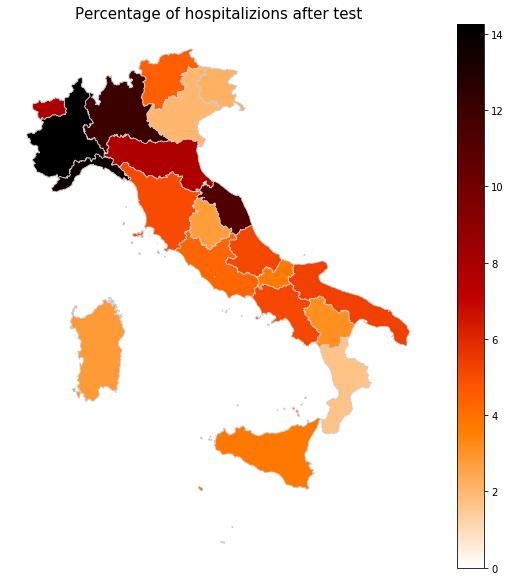

In [111]:
hosp_to_test = []
for rname in current_df.index.to_list():
    hosp_to_test.append(current_df.at[rname,'totale_ospedalizzati']*100/current_df.at[rname, 'tamponi'])
    
ht_dict = dict(zip(['Regions','percentuale_ospedalizzati'],[current_df.index.to_list(), hosp_to_test]))
ht_df = pd.DataFrame(ht_dict)
ht_df.set_index('Regions', inplace = True)

fig, ax = plt.subplots(1,figsize=(10,10))
plot_current(ax, 'percentuale_ospedalizzati', ht_df, map_df, 'Percentage of hospitalizions after test')

In [112]:
get_increment_df(regions_dataframe, delay_day = 0)

,inc_totale_casi,inc_totale_attualmente_positivi,inc_deceduti,inc_dimessi_guariti,inc_tamponi,inc_totale_ospedalizzati,inc_terapia_intensiva
Friuli Venezia Giulia,44,21,11,12,674,14,1
Marche,185,161,22,2,547,15,2
Puglia,91,74,15,2,861,-3,1
Umbria,54,-1,3,52,657,9,2
Veneto,428,338,30,60,5404,38,11
Toscana,305,275,17,13,1966,16,-2
Trentino-Alto Adige,194,164,9,21,1358,22,8
Basilicata,20,19,1,0,164,5,-1
Emilia-Romagna,736,571,99,66,0,91,17
Abruzzo,160,142,12,6,727,16,-2


In [113]:
dmax = len(r_timeseries['Veneto']['totale_casi'])

def plot_day_increase(regions_dataframe, fname, title, map_df, d = 0):
    
    idf = get_increment_df(regions_dataframe, delay_day = d)
    cdf = get_current_df(regions_dataframe, delay_day = d + 1)
    
    increase = []
    for rname in cdf.index.to_list():
        increase.append(idf['inc_' + fname][rname]/cdf[fname][rname]*100)
    
    dfname = 'aumento_giornaliero_' + fname
    
    inc_dict = dict(zip(['Regions', dfname],[cdf.index.to_list(), increase]))
    inc_df = pd.DataFrame(inc_dict)
    inc_df.set_index('Regions', inplace = True)

    fig, ax = plt.subplots(1,figsize=(10,10))
    plot_current(ax, dfname, inc_df, map_df, title)

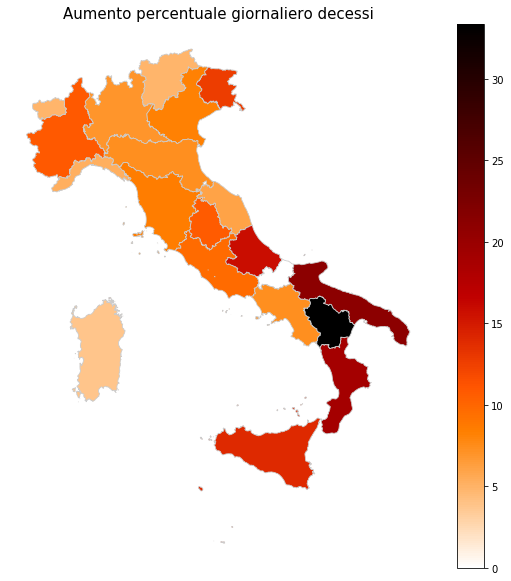

In [114]:
plot_day_increase(regions_dataframe, 'deceduti', "Aumento percentuale giornaliero decessi", map_df, d = 0)

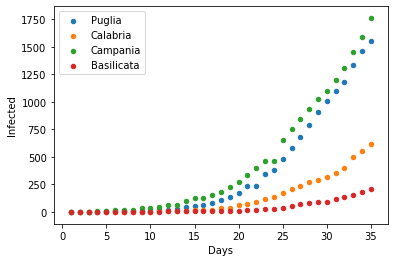

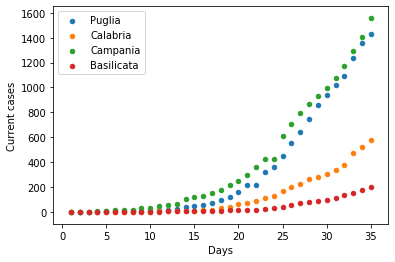

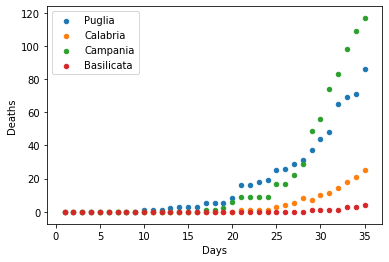

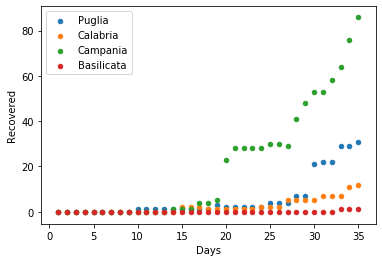

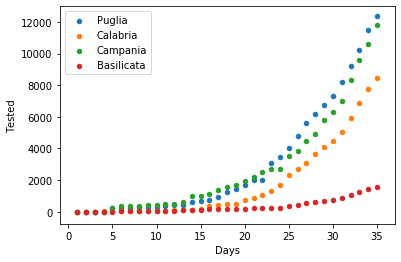

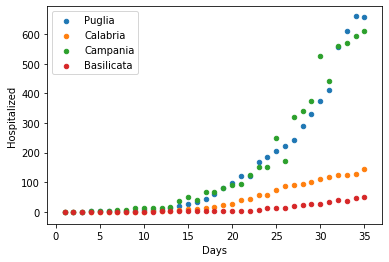

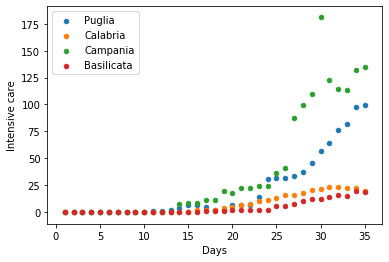

In [115]:
nlist = ['Puglia', 'Calabria', 'Campania', 'Basilicata']
for fname, fname_lab in zip(fields_names, fields_names_lab):
    plot_comparison(regions_dataframe, nlist, fname, fname_lab)